# Exploratory Data Analysis

 - Wind forecast and wind power from __2009/07/01 to 2011/01/01__, the initial train phase
 - Wind forecast and wind power on 36 hours phases between each of the 157 test periods on which you can retrain you models

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
training_data_1 = pd.read_csv("Data/Initial/train.csv")
testing_data_1 = pd.read_csv("Data/Initial/test.csv")

wp_1_forecast = pd.read_csv("Data/Initial/wp1.csv")
wp_2_forecast = pd.read_csv("Data/Initial/wp2.csv")
wp_3_forecast = pd.read_csv("Data/Initial/wp3.csv")
wp_4_forecast = pd.read_csv("Data/Initial/wp4.csv")
wp_5_forecast = pd.read_csv("Data/Initial/wp5.csv")
wp_6_forecast = pd.read_csv("Data/Initial/wp6.csv")

Pour limiter mon training set j'utilise l'heure du dernier forecast avant les prédictions et non les heures prédites par le forecast, afin de ne pas utiliser des données dans le future tout en conservant celles du future qui ont été prédites dans le passé. Par contre pour le testing data j'ai choisi d'utiliser un créneau plus large que la date de départ, afin d'avoir les 4 forecast de 36h précedents les premières heures de prédiction à fournir. Cela permettra de faire du rolling windows sur ces données et de récupérer les 4 prédictions des features.

In [3]:
# 36hrs before the real start date of the prediction
before_start_36h = '2010-12-30 13:00:00'
start_date = '2011-01-01 01:00:00'
start_forecastdate = '2011-01-01 00:00:00'
without_wp_date = '2010-12-30 12:00:00'
end_date = '2012-06-25 00:00:00'

In [4]:
# datetime(2011,1,1,1,0,0)+timedelta(hours=(36+48)*155)-timedelta(hours=36)

datetime.datetime(2012, 6, 25, 1, 0)

# Functions

In [5]:
def integer2date(s):
    s = str(s)
    return  datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]), hour=int(s[8:]))

def adding_hours(h):
    return timedelta(hours = h)

def date_conversion(df):
    df['forecast_time'] = df.date.apply(lambda x: integer2date(x))
    df['hours_added'] = df.hors.apply(lambda x: adding_hours(x))
    df['date'] = df['forecast_time'] + df['hours_added']
    df = df.drop(['hours_added', 'hors'], axis = 1)
    return df

In [25]:
def hr_func(ts):
    return ts.hour

def month_func(ts):
    return ts.month

def feature_engineering(data):
    # Voir si il y a une temporalité dans les saisons puisqu'on ne sait pas ou l'on se trouve sur le globe...
    
    data['cos_hour'] = np.cos(2*np.pi *(data['date']).apply(hr_func)/24)
    data['sin_hour'] = np.sin(2*np.pi *(data['date']).apply(hr_func)/24)
    
    data['cos_month'] = np.cos(2*np.pi *data['date'].apply(month_func)/12)
    data['sin_month'] = np.sin(2*np.pi *data['date'].apply(month_func)/12)
    
    #Ajouter le traintement de u et v
    
    data['cosWind_direction'] = np.cos(data['wd'])
    data['sinWind_direction'] = np.sin(data['wd'])

    data['cosws'] = np.cos(data['ws'])
    data['sinws'] = np.sin(data['ws'])

    data['ws3'] = np.cos(data['ws']**3)
    
    return data

In [7]:
def rolling_windows(data):
    ## WIND SPEED
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 12, 24]:
        data['ws_T_' + str(i)] = data['ws'].shift(i)     
    
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24]:
        data['ws_T_' + str(i) + '_mean'] = data['ws'].rolling(window = i).mean() 
        
    for i in [2, 3, 4, 5, 6, 12]:
        data['ws_T_' + str(i) + '_std'] = data['ws'].rolling(window = i).std()
        
    for i in [2, 3, 4, 5, 6, 12]:
        data['ws_T_' + str(i) + '_median'] = data['ws'].rolling(window = i).median()
        
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        data['ws_T_' + str(i) + '_max'] = data['ws'].rolling(window = i).max()    
        
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        data['ws_T_' + str(i) + '_min'] = data['ws'].rolling(window = i).min()         
       
    ## X_com 
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        data['x_T_' + str(i)] = data['u'].shift(i)
        
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data['x_T_' + str(i) + '_mean'] = data['u'].rolling(window = i).mean()  
        
    for i in [2, 3, 4, 5, 6]:
        data['x_T_' + str(i) + '_std'] = data['u'].rolling(window = i).std()     
        
    ## Y_com
    for i in [1, 2, 3, 4, 5, 6, 12, 24]:
        data['y_T_' + str(i)] = data['v'].shift(i)
        
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data['y_T_' + str(i) + '_mean'] = data['v'].rolling(window = i).mean()  
        
    for i in [2, 3, 4, 5, 6]:
        data['y_T_' + str(i) + '_std'] = data['v'].rolling(window = i).std()        

    return data

# Date correction

In [8]:
training_data_1['date'] = training_data_1.date.apply(lambda x: integer2date(x))

In [9]:
testing_data_1['date'] = testing_data_1.date.apply(lambda x: integer2date(x))

# WP1 analysis

Au vu de la répartition du temps, le mieux serait d'utiliser un modèle ML avec une matrice 48h en entrée et 48h en sorti. </br>
Dans le set de training, on a 1095 forecast de 48h complet. Le test commence au forecast 1099.0 </br>
**To discuss**: Est ce que forecast de la date du test peut être conservée si elle a été émise avant la date test ? (Selon moi oui, mais ce sera dommage d'être disqualifiés pour ça)

Defines batch of forecasts for QC:

In [10]:
i = 1
for date in wp_1_forecast.date.unique():
    wp_1_forecast.loc[wp_1_forecast.date == date, 'cast'] = i
    i += 1

Converts the date corresponding to the forecast and also the forecast date

In [11]:
wp_1_forecast = date_conversion(wp_1_forecast)
wp_1_forecast = feature_engineering(wp_1_forecast)

In [12]:
# Gets the right wind power value for each date of the dataset
wp_1_target = training_data_1[['date','wp1']]
for date in wp_1_target.date.unique():
     wp_1_forecast.loc[wp_1_forecast.date == date, 'wp1'] = wp_1_target.loc[wp_1_target.date == date, 'wp1'].values[0]

Use this to see the count of data (nice when you want to be sure you have 4 counts) :

In [13]:
# wp_1_test_data = wp_1_forecast[(wp_1_forecast.date >= start_date)].sort_values(by='date').head(4*48+4*36)
# wp_1_test_data.groupby([wp_1_test_data["date"].dt.year, wp_1_test_data["date"].dt.month, wp_1_test_data["date"].dt.day,  wp_1_test_data["date"].dt.hour]).count().plot(kind="bar", figsize=(40,5))

# Separation into training and testing data

In [14]:
wp_1_training = wp_1_forecast[(wp_1_forecast.forecast_time < without_wp_date)]

For the predicted data, I choose to take a larger sample in order to use the rolling_windows function

In [15]:
wp_1_testing = wp_1_forecast[(wp_1_forecast.date >= before_start_36h)]

# WP1 preprocessing training data

Le but est de récuperer les 24h précedentes afin de faire du rolling windows pour chaque 48h à prédire.</br>
**To do:** Les saisons - 

In [16]:
wp_1_training = feature_engineering(wp_1_training)

In [17]:
training_data = pd.DataFrame()
                                    
for i in range(4, int(len(wp_1_training)/48 + 1)):
    # Ici on garde 2 des 48h de prediction différentes (pour avoir 24h (ou 36h) avant) + 48h qui seront a prédire afin de faire du rolling windows
    # i correspond au cast à garder de 48h
    condition = (wp_1_training.cast >= i-2) & (wp_1_training.cast <= i)
    forecast_48 = wp_1_training[condition].sort_values(by = ['date', 'forecast_time'], ascending=[True, False])
    forecast_48 = forecast_48.drop_duplicates(subset = 'date')
    forecast_48 = rolling_windows(forecast_48)
    forecast_48 = forecast_48[forecast_48.cast == i]
    training_data = pd.concat([training_data, forecast_48], ignore_index=True)

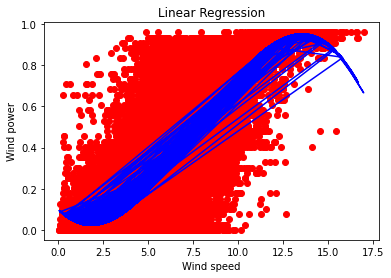

In [24]:
X = training_data['ws'].values.reshape(-1, 1)
y = training_data['wp1'].values.reshape(-1, 1)


poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

def viz_polymonial(X, y, pol_reg):
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Wind speed')
    plt.ylabel('Wind power')
    plt.show()
    return

# training_data['theoretical_power'] = pol_reg.predict(poly_reg.fit_transform(X))
viz_polymonial(X, y, pol_reg)

# WP1 preprocessing - testing data

Ici je récupère les indices des forecasts de 48h à prédire. 

In [ ]:
wp_1_testing = feature_engineering(wp_1_testing)

In [ ]:
first_test_forecast = wp_1_testing[wp_1_testing.forecast_time >= start_forecastdate].head(1)['cast'].values[0]
nb_forecast = int(len(testing_data_1)/48)
cast_predict = [first_test_forecast]

for i in range(1, nb_forecast):
    cast_predict.append(cast_predict[i-1] + 7)

In [ ]:
testing_data = pd.DataFrame()
for i in cast_predict:
    # Ici on garde 2 des 48h de prediction différentes (pour avoir 24h (ou 36h) avant) + 48h qui seront a prédire afin de faire du rolling windows
    # i correspond au cast à garder de 48h
    condition = (wp_1_testing.cast >= i-2) & (wp_1_testing.cast <= i)
    forecast_48 = wp_1_testing[condition].sort_values(by = ['date', 'forecast_time'], ascending=[True, False])
    forecast_48 = forecast_48.drop_duplicates(subset = 'date')
    forecast_48 = rolling_windows(forecast_48)
    forecast_48 = forecast_48[forecast_48.cast == i]
    testing_data = pd.concat([testing_data, forecast_48], ignore_index=True)